<a href="https://colab.research.google.com/github/mitmul/learn-chainer/blob/master/src/11_Regression_with_Neural_Networks_ja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ニューラルネットワークによる回帰

この章では、回帰問題に Chainer を利用する方法を説明します。
分類ではカテゴリを予測するモデルを作成しました。
今回説明する回帰では 、連続値の予測を行います。


## 問題設定

今回は 6 章で用いたのと同じ住宅価格のデータを集めた Boston house prices dataset を利用します。
このデータセットは入力変数の種類が13個あり、目標値が住宅価格になっています。

## データセットの準備

### データセットの読み込み

Boston house prices dataset は scikit-learn の `load_boston()` で取得できます。

In [1]:
import sklearn.datasets

# データセットの読み込み
boston = sklearn.datasets.load_boston()
x = boston.data
t = boston.target

次にこのデータセットの中身を表示して確認してみます。
まずは入力変数を見てみます。
項目が多いので、綺麗に表示できる Pandas の DataFrame を使って表示してみます。
入力変数のデータは `boston.data`、入力変数の各行の名前は `boston.feature_names` に入っています。

In [2]:
import pandas as pd

# 最初の3行を表示
pd.DataFrame(boston.data, columns=boston.feature_names)[:3]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03


行が各入力変数、列がサンプルを表しています。
各列が何を意味しているかは[6.2 scikit-learn（応用編）]()で説明されていますので、参照してください。

次に、モデルの出力となる目標値の確認をしてみます。
目標値は `boston.target` に入ってますので、これを表示してみます。

In [3]:
# 最初の3つを表示
boston.target[:3]

array([24. , 21.6, 34.7])

### 入力変数と目標値に切り分ける

それでは、入力変数と目標値を取り出し、それぞれ `x` と `t` に代入します。


In [4]:
x = boston.data
t = boston.target

### 訓練データ・検証データ・テストデータに分割

次に、下図のようにまずデータセットを `train_val` と `test` という 2 つに分割し、さらに `train_val` を `train` と `val` に分割することで、最終的に 3 つに分割します。

![データセットの分割](https://github.com/mitmul/learn-chainer/blob/master/src/images/11/11_02.png?raw=1)

In [5]:
from sklearn.model_selection import train_test_split

x_train_val, x_test, t_train_val, t_test = train_test_split(x, t, train_size=0.7, random_state=0)
x_train, x_valid, t_train, t_valid = train_test_split(x_train_val, t_train_val, train_size=0.7, random_state=0)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### 前処理

ここでは 6 章と同様にデータセットの標準化を行います。
標準化に用いる平均値と分散の値を訓練データセットだけから計算し、検証データセットやテストデータセットのデータを用いないように注意します。

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)
x_test = scaler.transform(x_test)

### Chainer で使うデータセットに変換

Chainer を用いて定義した重回帰分析を行うニューラルネットワークにこのデータセットを入力する際には、以下の 3 点に注意する必要があります。

- 入力変数と目標値が NumPy もしくは CuPy の `ndarray` の形式になっている
- 入力変数の形が `(サンプル数, 入力変数の数)` になっている
- 目標値の形が `(サンプル数, 目標値の数)` になっている


scikit-learn の `load_boston()` 関数で読み込んだデータセットは、既に NumPy の ndarray 形式になっています。
また、入力変数の形は、

In [7]:
print('x_train:', x_train.shape)
print('x_valid:', x_valid.shape)
print('x_test:', x_test.shape)

x_train: (247, 13)
x_valid: (107, 13)
x_test: (152, 13)


です。
すべて、`(サンプル数, 入力変数の数)` となっています。

一方、目標値の `t` の形を確認すると、

In [8]:
print('t_train:', t_train.shape)
print('t_valid:', t_valid.shape)
print('t_test:', t_test.shape)

t_train: (247,)
t_valid: (107,)
t_test: (152,)


となっています。
今、目標値の種類数は 1 なので、これは `(サンプル数, 1)` という形に変形する必要があります。
変形は以下のようにして行います。
変形を行ったあとに、形を表示して目的の形になっていることを確認します。

In [9]:
t_train = t_train.reshape(len(t_train), 1)
t_valid = t_valid.reshape(len(t_valid), 1)
t_test = t_test.reshape(len(t_test), 1)

print('t_train:', t_train.shape)
print('t_valid:', t_valid.shape)
print('t_test:', t_test.shape)

t_train: (247, 1)
t_valid: (107, 1)
t_test: (152, 1)


また、Chainer では浮動小数点数は `float32` 型で扱われるのがデフォルトとなっています。
しかし、今回は `x` も `t` も `float64` 型となっています。
このため、データ型の変換も行います。
変換のあとに、データ型の確認も行います。

In [10]:
# データ型の変換
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')

t_train = t_train.astype('float32')
t_valid = t_valid.astype('float32')
t_test = t_test.astype('float32')

# データ型の確認

print('x_train:', x_train.dtype)
print('x_val:', x_valid.dtype)
print('x_test:', x_test.dtype)

print('t_train:', t_train.dtype)
print('t_val:', t_valid.dtype)
print('t_test:', t_test.dtype)

x_train: float32
x_val: float32
x_test: float32
t_train: float32
t_val: float32
t_test: float32


最後に、下図のように、`zip(x, t)` で入力変数と目標値のペアをタプルにして並べたものを `list()` 関数を用いてリストにし、Chainer で使用できるデータセットの形式に変換します。
**Chainer で使用できるデータセットの形式**とは、端的には教師データ（入力と教師信号のペア）が並んだリストのことでした。

![入力変数と目標値のタプルのリスト](https://github.com/mitmul/learn-chainer/blob/master/src/images/11/11_01.png?raw=1)

Chainer のデータセットの形式にし、各データセットごとのサイズを確認します。

In [11]:
# Chainerで使用できるデータセットの形式
train = list(zip(x_train, t_train))
valid = list(zip(x_valid, t_valid))
test = list(zip(x_test, t_test))

print(len(train))
print(len(valid))
print(len(test))

247
107
152


## Chain を継承したネットワークの定義

今回は、3 層の全結合型ニューラルネットワークを定義します。

回帰を行うネットワークも分類を行うネットワークと記述方法は基本的に同じです。
異なる部分として、目標値が １ 変数の回帰問題の場合は、出力 `n_output` が `1` となる点があります。

In [12]:
import numpy as np

import chainer
import chainer.links as L
import chainer.functions as F


# ネットワークの定義
class NN(chainer.Chain):

    def __init__(self, n_input=13, n_hidden=5, n_output=1):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(n_input, n_hidden)
            self.l2 = L.Linear(n_hidden, n_output)

    def forward(self, x):
        h = F.relu(self.l1(x))
        h = self.l2(h)
        return h

モデルが定義できたら、インスタンス化します。
この際、まず NumPy の seed を固定し、初期値が毎回同じになるようにしています。

In [13]:
# シードの固定
np.random.seed(0)

# インスタンス化（デフォルトの引数値を使用）
model = NN()

## モデルの訓練

確率的勾配降下法 (SGD) を最適化アルゴリズムとして採用し、モデルの訓練を行います。

流れは前章で紹介した分類の場合と同じですが、以下の 2 点が分類を行う場合からの変更点です。

- 損失関数：`softmax_cross_entropy` -> `mean_squared_error`
- 指標：`accuracy` -> `r2_score`

ここで、`r2_score` は 6 章の重回帰分析の説明の際に紹介した[決定係数](https://docs.chainer.org/en/stable/reference/generated/chainer.functions.r2_score.html)を計算するための Chainer の関数です。

In [14]:
from sklearn.preprocessing import StandardScaler

# 定数の定義
n_batch = 64  # バッチサイズ
n_epoch = 50  # エポック数

# optimizer の定義と model との紐付け
optimizer = chainer.optimizers.SGD()
optimizer.setup(model)

# ログ記録用
results_train, results_valid = {}, {}
results_train['loss'], results_train['r2_score'] = [], []
results_valid['loss'], results_valid['r2_score'] = [], []

# iterator の定義
train_iter = chainer.iterators.SerialIterator(train, n_batch)
valid_iter = chainer.iterators.SerialIterator(valid, n_batch, repeat=False, shuffle=False)

iteration = 1

for epoch in range(n_epoch):
    
    while True:
        
        # ミニバッチの取得
        train_batch = train_iter.next()
        
        # x と t に分割
        x_train, t_train = chainer.dataset.concat_examples(train_batch)

        # 予測値と目的関数の計算
        y_train = model(x_train)
        loss_train = F.mean_squared_error(y_train, t_train)
        r2_score_train = F.r2_score(y_train, t_train)

        # 勾配の初期化と勾配の計算
        model.cleargrads()
        loss_train.backward()

        # パラメータの更新
        optimizer.update()

        # カウントアップ
        iteration += 1

        # 1エポック終えたら、valid データで評価する
        if train_iter.is_new_epoch:
            
            # ミニバッチの取得
            valid_batch = valid_iter.next()
            
            # x と t に分割
            x_valid, t_valid = chainer.dataset.concat_examples(valid_batch)
    
            # 検証用データに対する結果の確認
            with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
                y_valid = model(x_valid)
                loss_valid = F.mean_squared_error(y_valid, t_valid)
                r2_score_valid = F.r2_score(y_valid, t_valid)

            # 結果の表示
            # {:.4f} と指定することで、小数点以下4桁までを表示します
            print('epoch: {}, iteration: {}, loss (train): {:.4f}, loss (valid): {:.4f}'.format(
                epoch, iteration, loss_train.array, loss_valid.array))

            # ログを保存
            results_train['loss'] .append(loss_train.array)
            results_train['r2_score'] .append(r2_score_train.array)
            results_valid['loss'].append(loss_valid.array)
            results_valid['r2_score'].append(r2_score_valid.array)
            
            valid_iter.reset()
            break

epoch: 0, iteration: 5, loss (train): 457.2360, loss (valid): 462.2869
epoch: 1, iteration: 9, loss (train): 261.6778, loss (valid): 75.3184
epoch: 2, iteration: 13, loss (train): 31.9611, loss (valid): 29.2378
epoch: 3, iteration: 17, loss (train): 25.3223, loss (valid): 21.2279
epoch: 4, iteration: 21, loss (train): 21.8097, loss (valid): 20.6121
epoch: 5, iteration: 25, loss (train): 20.9949, loss (valid): 16.4250
epoch: 6, iteration: 29, loss (train): 8.6116, loss (valid): 16.1474
epoch: 7, iteration: 32, loss (train): 28.0595, loss (valid): 14.6034
epoch: 8, iteration: 36, loss (train): 22.2533, loss (valid): 13.8538
epoch: 9, iteration: 40, loss (train): 15.2179, loss (valid): 13.3275
epoch: 10, iteration: 44, loss (train): 23.7030, loss (valid): 13.6612
epoch: 11, iteration: 48, loss (train): 14.0824, loss (valid): 14.1666
epoch: 12, iteration: 52, loss (train): 12.6989, loss (valid): 13.8337
epoch: 13, iteration: 56, loss (train): 22.2217, loss (valid): 13.6566
epoch: 14, itera

学習が終わりました。

損失と決定係数が訓練が進むにつれてどのように変化したかを確認します。

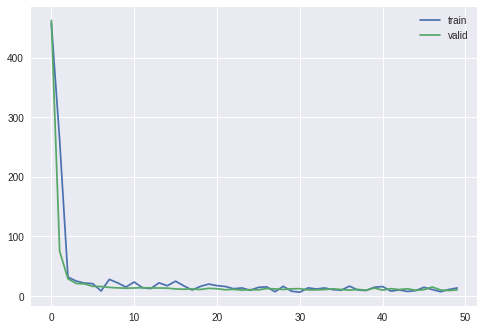

In [15]:
import matplotlib.pyplot as plt

# 損失 (loss)
# 横軸はエポックではなく、イテレーション
plt.plot(results_train['loss'], label='train')  # label で凡例の設定
plt.plot(results_valid['loss'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示
plt.show()

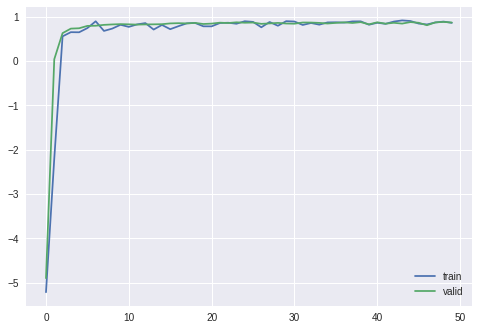

In [16]:
# 決定係数 (r2_score)
# 横軸はエポックではなく、イテレーション
plt.plot(results_train['r2_score'], label='train')  # label で凡例の設定
plt.plot(results_valid['r2_score'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示
plt.show()

次にテストデータに対して、損失と決定係数を計算し、表示します。

In [17]:
# テストデータに対する結果の確認
x_test, t_test = chainer.dataset.concat_examples(test)
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_test = model(x_test)
    loss_test = F.mean_squared_error(y_test, t_test)
    r2_score_test = F.r2_score(y_test, t_test)
    
print('test loss: {:.4f}'.format(loss_test.array))
print('test_r2_score: {:.4f}'.format(r2_score_test.array))

test loss: 18.3576
test_r2_score: 0.7795


## GPU を用いた計算

今回使用したデータセットはデータ数が少なく、また訓練したニューラルネットワークもパラメータ数は多くありませんでした。
そのため、CPU を使ってもそこまで長く待たされることなく訓練が終了しました。

しかし、より大きなデータセットを使い、より多くの層を持つニューラルネットワークを訓練しようとすると、CPU だけでは膨大な時間がかかってしまいます。
そこで、GPU を使って計算を高速化する方法についても、ここで紹介します。

まず、GPU が使える環境であることを確認しましょう。

Google Colaboratory ではメニュー項目の「ランタイム」から「ランタイムのタイプを変更」を選択し、「ハードウェアアクセラレータ」と書かれたプルダウンメニューからから GPU を指定することができます。
さっそく GPU を有効にしてください。

また、一台のマシンに複数の GPU を挿して用いる場合もあるため、GPU を用いる際は**デバイス ID** というものを意識する必要がありますが、Google Colaboratory では利用できる GPU が 1 枚だけなので、このデバイス ID としては基本的に `0` を指定すれば良いことになります。

In [18]:
# GPU デバイスの指定
gpu_id = 0

# 計算に指定したデバイス ID の GPU を使うことを宣言
device = chainer.backends.cuda.get_device_from_id(gpu_id)
device.use()

In [19]:
import cupy as cp

# 乱数のシードを固定
np.random.seed(0)
cp.random.seed(0)

CPUと同様にモデルをインスタンス化します。
その後、モデルをGPUに転送します。

In [20]:
# インスタンス化
model = NN()

 # モデルをGPUへ転送
model.to_gpu(gpu_id) 

In [21]:
# 定数の定義
n_batch = 64  # バッチサイズ
n_epoch = 50  # エポック数

# optimizer の定義と model と紐付け
optimizer = chainer.optimizers.SGD()
optimizer.setup(model)

# 可視化用のリスト
results_train, results_valid = {}, {}
results_train['loss'], results_train['r2_score'] = [], []
results_valid['loss'], results_valid['r2_score'] = [], []

# iterator の定義
train_iter = chainer.iterators.SerialIterator(train, n_batch)
valid_iter = chainer.iterators.SerialIterator(valid, n_batch, repeat=False, shuffle=False)

count = 1

for epoch in range(n_epoch):
    
    while True:
        
        # ミニバッチの取得
        train_batch = train_iter.next()
        
        # x と t に分割
        # データを GPU に転送するために、concat_examples に gpu_id を渡す
        x_train, t_train = chainer.dataset.concat_examples(train_batch, gpu_id)

        # 予測値と目的関数の計算
        y_train = model(x_train)
        loss_train = F.mean_squared_error(y_train, t_train)
        r2_score_train = F.r2_score(y_train, t_train)

        # 勾配の初期化と勾配の計算
        model.cleargrads()
        loss_train.backward()

        # パラメータの更新
        optimizer.update()
    
        # カウントアップ
        count += 1

        # 1エポック終えたら、valid データで評価する
        if train_iter.is_new_epoch:

            valid_batch = valid_iter.next()           
            x_valid, t_valid = chainer.dataset.concat_examples(valid_batch, gpu_id)

            # 検証用データに対する結果の確認
            with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
                y_valid = model(x_valid)
                loss_valid = F.mean_squared_error(y_valid, t_valid)
                r2_score_valid = F.r2_score(y_valid, t_valid)
            
            # 注意：GPU で計算した結果はGPU上に存在するため、CPU上に転送します
            loss_train.to_cpu()
            loss_valid.to_cpu()
            r2_score_train.to_cpu()
            r2_score_valid.to_cpu()

            # 結果の表示
            print('epoch: {}, iteration: {}, loss (train) {:.4f}, loss (valid) {:.4f}'.format(
                epoch, count, loss_train.array, loss_valid.array))

            # 可視化用に保存
            results_train['loss'] .append(loss_train.array)
            results_train['r2_score'] .append(r2_score_train.array)
            results_valid['loss'].append(loss_valid.array)
            results_valid['r2_score'].append(r2_score_valid.array)
            
            valid_iter.reset()
            break

epoch: 0, iteration: 5, loss (train) 457.2360, loss (valid) 462.2869
epoch: 1, iteration: 9, loss (train) 261.6778, loss (valid) 75.3184
epoch: 2, iteration: 13, loss (train) 31.9611, loss (valid) 29.2378
epoch: 3, iteration: 17, loss (train) 25.3223, loss (valid) 21.2279
epoch: 4, iteration: 21, loss (train) 21.8096, loss (valid) 20.6121
epoch: 5, iteration: 25, loss (train) 20.9949, loss (valid) 16.4250
epoch: 6, iteration: 29, loss (train) 8.6116, loss (valid) 16.1474
epoch: 7, iteration: 32, loss (train) 28.0595, loss (valid) 14.6034
epoch: 8, iteration: 36, loss (train) 22.2533, loss (valid) 13.8538
epoch: 9, iteration: 40, loss (train) 15.2179, loss (valid) 13.3275
epoch: 10, iteration: 44, loss (train) 23.7030, loss (valid) 13.6612
epoch: 11, iteration: 48, loss (train) 14.0824, loss (valid) 14.1666
epoch: 12, iteration: 52, loss (train) 12.6989, loss (valid) 13.8337
epoch: 13, iteration: 56, loss (train) 22.2217, loss (valid) 13.6566
epoch: 14, iteration: 59, loss (train) 17.46

学習が終了しました。

CPU で実行したときと同様に、損失と決定係数が訓練が進むにつれてどのように変化していったかを確認してみます。

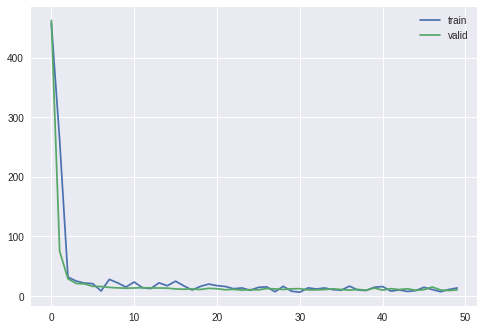

In [22]:
# 損失 (loss)
# 横軸はエポックではなく、イテレーション
plt.plot(results_train['loss'], label='train')  # label で凡例の設定
plt.plot(results_valid['loss'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示

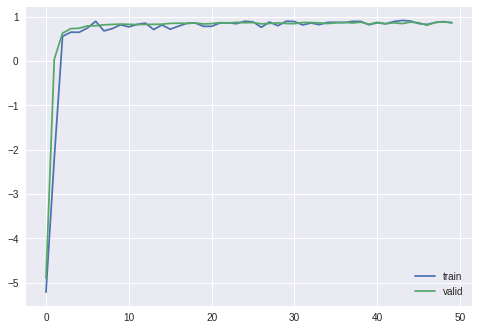

In [23]:
# 決定係数 (r2_score)
# 横軸はエポックではなく、イテレーション
plt.plot(results_train['r2_score'], label='train')  # label で凡例の設定
plt.plot(results_valid['r2_score'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示

上記の学習ループの中でもコメントで説明を行っていますが、モデルもデータも GPU 上に転送した上で計算しているため、`print()` などの関数を使用する場合には、まず CPU 上へ転送する必要があります。
この CPU への転送には `to_cpu()` メソッドが便利です。

最後に GPU で学習したモデルをテストデータで評価します。


In [24]:
# テストデータに対する損失と決定件数を計算
x_test, t_test = chainer.dataset.concat_examples(test, device=gpu_id)
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_test = model(x_test)
    loss_test = F.mean_squared_error(y_test, t_test)
    r2_score_test = F.r2_score(y_test, t_test)

print('test loss: {:.4f}'.format(loss_test.array.get()))
print('test_r2_score: {:.4f}'.format(r2_score_test.array.get()))

test loss: 18.3576
test_r2_score: 0.7795


CPU を使って訓練した際に得られたスコア

> test loss: 18.3576  
> test_r2_score: 0.7795

と小数点以下 4 桁まで全く同じスコアが得られています。

データセットの規模が大きくなってくると、GPU を用いるほうがはるかに高速に計算することができます。